#### Get Dataset from Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
import cv2,os

import sys
sys.path.append('../')
from models.utils.util import  *
from models.env.manipulator_agent import ManipulatorAgent

In [2]:
xml_path = '../asset/ur5e/scene-w-ground-block.xml'
# MODE = 'window' ################### 'window' or 'offscreen'
MODE = 'offscreen' ################### 'window' or 'offscreen'
env = ManipulatorAgent(rel_xml_path=xml_path,VERBOSE=False, MODE=MODE)
env.close_viewer()

MODE: offscreen


In [3]:
# Place objects
object_names = ["obj_box_red", "obj_box_blue", "obj_box_green", 
                "obj_box_yellow", "obj_box_gray", "obj_box_magenta"]

obj_box_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("obj_box"))]
n_obj = 6 # len(obj_names)
xyzs = sample_xyzs(
    n_sample=n_obj,x_range=[0.55,1.05],y_range=[-0.35,0.35],z_range=[0.74,0.80],min_dist=0.2,xy_margin=0.0)

for obj_idx, obj_box_name in zip(range(n_obj), obj_box_names):
    color_idx = obj_idx % 3
    box_jntadr = env.model.body(obj_box_name).jntadr[0]
    env.model.joint(box_jntadr).qpos0[:3] = xyzs[obj_idx, :]

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0.395])
env.model.body('front_object_table').pos = np.array([-38+0.6,0,0])
env.model.body('side_object_table').pos = np.array([0.38+0.4,0.0,0])
env.model.body('ur_base').pos = np.array([0.18,0,0.79])
env.model.body('ur_base').pos = np.array([0.18,0,0.8]) # robot base
for body_name in ['base_table','front_object_table','side_object_table']:
    geomadr = env.model.body(body_name).geomadr[0]
    env.model.geom(geomadr).rgba[3] = 1.0

print ("Ready.")

Ready.


#### Capture Scene

MODE: offscreen
MODE: offscreen


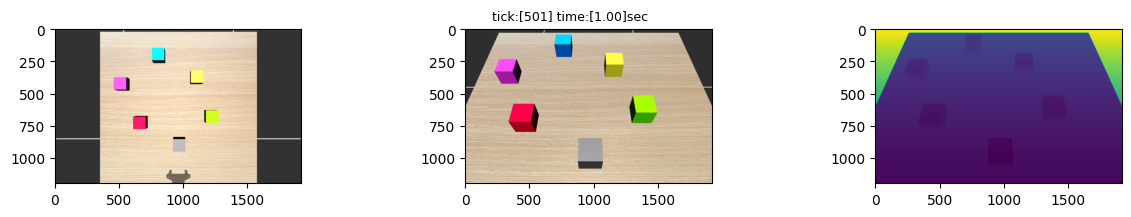

Done.


In [4]:
# Joint indices
rev_joint_names = ['shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
                   'wrist_1_joint','wrist_2_joint','wrist_3_joint']
idxs_ur_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
idxs_ur_jac = env.get_idxs_jac(joint_names=rev_joint_names)
idxs_ur_step = env.get_idxs_step(joint_names=rev_joint_names)

init_pose = np.array([-1.571, -2.1916,  1.7089,  2.0533,  1.1000, -1.5706])
init_pose = np.array([-1.57077466, -2.32822577,  2.32735698,  1.57164833,  0.96625407, -1.57076883])
env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)

# Place objects
object_names = ["obj_box_red", "obj_box_blue", "obj_box_green", 
                "obj_box_yellow", "obj_box_gray", "obj_box_magenta"]
obj_box_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("obj_box"))]
n_obj = 6 # len(obj_names)
xyzs = sample_xyzs(
    n_sample=n_obj,x_range=[0.6,1.05],y_range=[-0.3,0.3],z_range=[0.74,0.80],min_dist=0.2,xy_margin=0.0)

for obj_idx, obj_box_name in zip(range(n_obj), obj_box_names):
    color_idx = obj_idx % 3
    box_jntadr = env.model.body(obj_box_name).jntadr[0]
    env.model.joint(box_jntadr).qpos0[:3] = xyzs[obj_idx, :]

env.reset()
env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
env.set_viewer()
env.update_viewer(azimuth=0,distance=0.5,elevation=-90,lookat=[0.8,0.0,1.2],
                VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,
                jointrgba=[0.2,0.6,0.8,0.6])

FIRST_FLAG = True
while env.is_viewer_alive():
    # Step
    env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
    
    # Render
    if env.loop_every(HZ=1) and env.get_sim_time() >= 1.0:
        fig,axs = plt.subplots(1,3,figsize=(15,2))
        scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
        plt.subplots_adjust(wspace=0.2); plt.show()
        break

    # Clear flag
    FIRST_FLAG = False
env.close_viewer()
print ("Done.")

#### Move object with each preference objective: `Quadrant-based, Align with horizontal, vertical, ...`

In [5]:
def save_img(scene_img, rgb_img, img_idx, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    print(save_path+f'scene_img_{img_idx}.png')
    plt.imsave(save_path+f'scene_img_{img_idx}.png',scene_img)
    plt.imsave(save_path+f'rgb_img_{img_idx}.png',rgb_img)

In [6]:
def random_sample_object(env, obj_box_names):
    # Place objects
    obj_box_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_box"))]
    n_obj = 6 # len(obj_names)
    xyzs_box = sample_xyzs(
        n_sample=n_obj,x_range=[0.6,1.05],y_range=[-0.3,0.3],z_range=[0.74,0.80],min_dist=0.2,xy_margin=0.05)
        # n_sample=n_obj,x_range=[0.725,0.725],y_range=[-0.15,-0.15],z_range=[0.74,1.00],min_dist=0.0,xy_margin=0.0)

    for obj_idx, obj_box_name in zip(range(n_obj), obj_box_names):
        box_jntadr = env.model.body(obj_box_name).jntadr[0]
        env.model.joint(box_jntadr).qpos0[:3] = xyzs_box[obj_idx, :]

def get_quadrant_centers(env):
    table_center = env.get_p_body('side_object_table')
    quadrant_size = 0.225
    quadrants = {
        "upper": table_center + np.array([quadrant_size, 0, 0.70]),
        "lower": table_center - np.array([quadrant_size, 0, 0.70]),
        "left": table_center + np.array([0, quadrant_size, 0.7]),
        "right": table_center - np.array([0, quadrant_size, 0.7]),
        "center": table_center + np.array([0, 0, 0.7])
    }
    return quadrants

def get_object_positions(env, object_names):
    positions = {}
    for obj in object_names:
        positions[obj] = env.get_p_body(obj)
    return positions

MODE: offscreen
MODE: offscreen


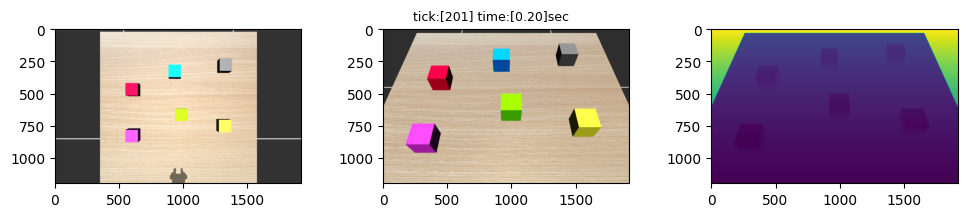

./block/horizontal/1/scene_img_0.png
horizontal: 0.9991334286072423
Moved object `obj_box_red` to ['0.999', '0.049', '0.848']


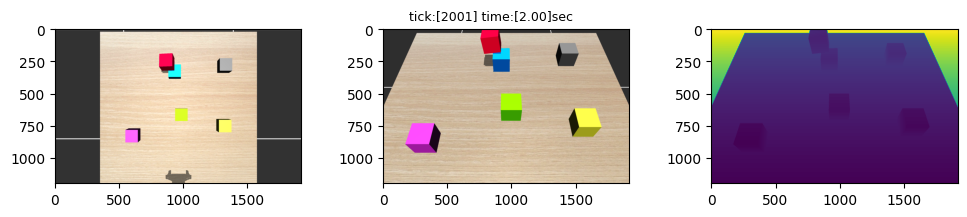

./block/horizontal/1/scene_img_1.png
horizontal: 0.9991334286072423
Moved object `obj_box_blue` to ['0.999', '0.211', '0.848']


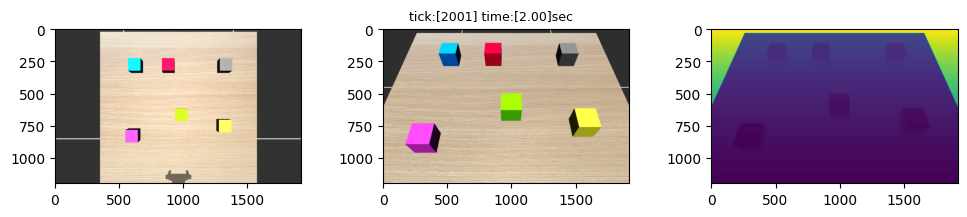

./block/horizontal/1/scene_img_2.png
horizontal: 0.9991334286072423
Moved object `obj_box_green` to ['0.999', '-0.166', '0.849']


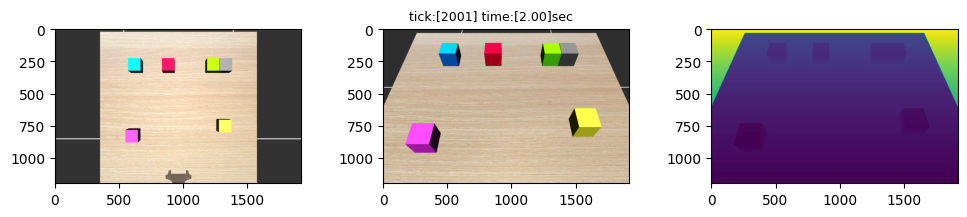

./block/horizontal/1/scene_img_3.png
horizontal: 0.9991334286072423
Moved object `obj_box_yellow` to ['0.999', '-0.370', '0.849']


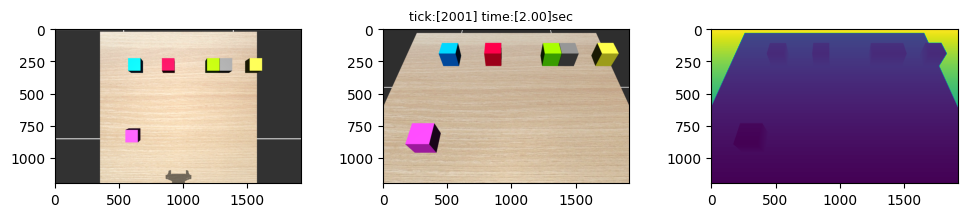

./block/horizontal/1/scene_img_4.png
horizontal: 0.9991334286072423
Moved object `obj_box_magenta` to ['0.999', '0.234', '0.848']


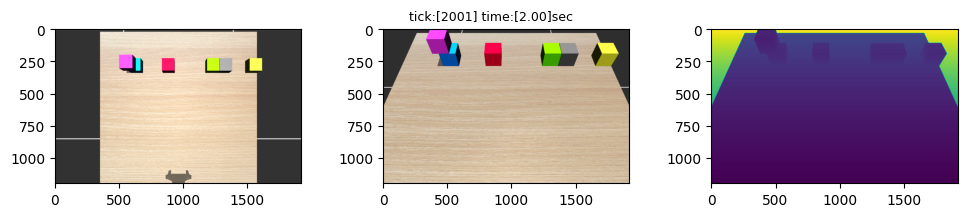

./block/horizontal/1/scene_img_5.png
[sample_xyzs] iter_tick:[1001] is over 1000.
MODE: offscreen
MODE: offscreen


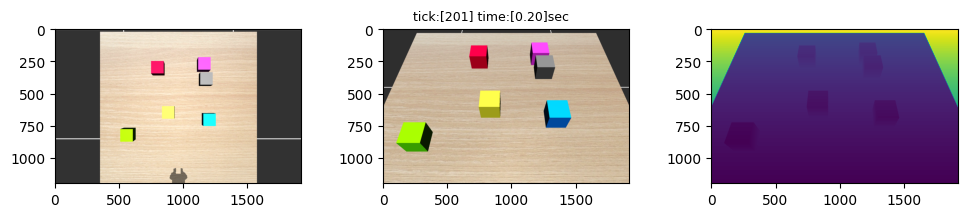

./block/horizontal/2/scene_img_0.png
horizontal: 0.7692052022625027
Moved object `obj_box_red` to ['0.769', '0.303', '0.848']


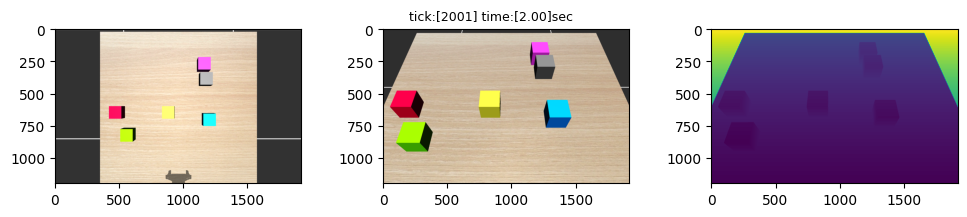

./block/horizontal/2/scene_img_1.png
horizontal: 0.7692052022625027
Moved object `obj_box_blue` to ['0.769', '-0.233', '0.848']


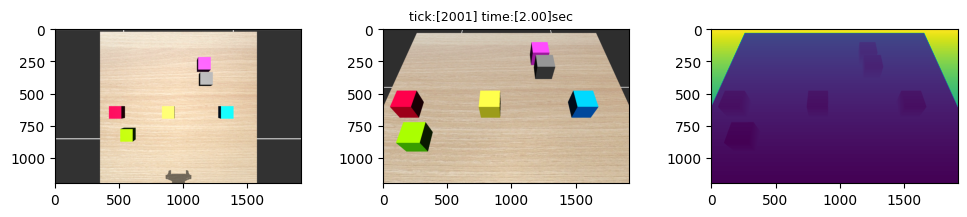

./block/horizontal/2/scene_img_2.png
horizontal: 0.7692052022625027
Moved object `obj_box_green` to ['0.769', '0.271', '0.849']


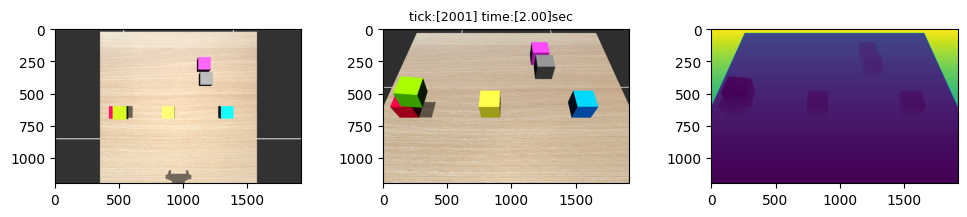

./block/horizontal/2/scene_img_3.png
horizontal: 0.7692052022625027
Moved object `obj_box_gray` to ['0.769', '-0.251', '0.848']


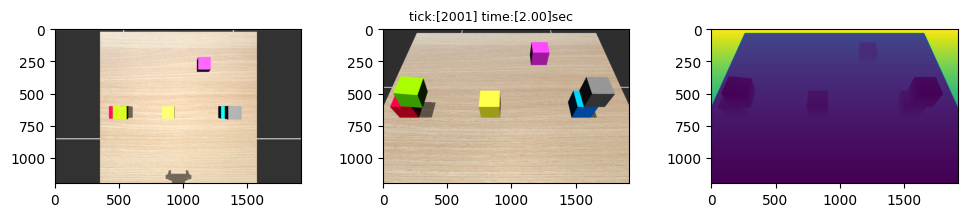

./block/horizontal/2/scene_img_4.png
horizontal: 0.7692052022625027
Moved object `obj_box_magenta` to ['0.769', '-0.274', '0.848']


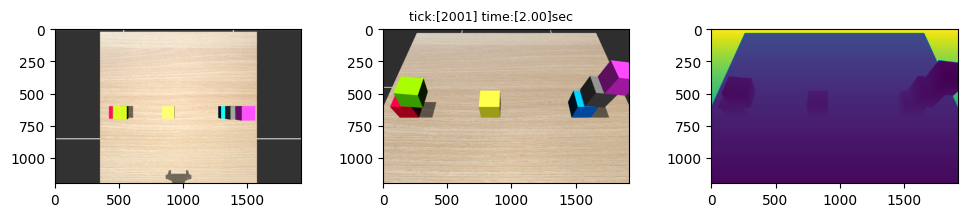

./block/horizontal/2/scene_img_5.png
[sample_xyzs] iter_tick:[1001] is over 1000.
[sample_xyzs] iter_tick:[1002] is over 1000.
MODE: offscreen
MODE: offscreen


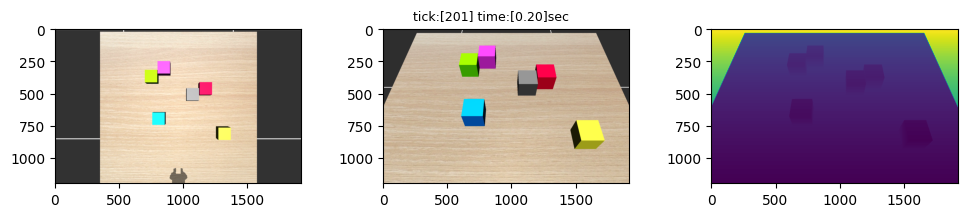

./block/horizontal/3/scene_img_0.png
horizontal: 0.7392316683111209
Moved object `obj_box_red` to ['0.739', '0.078', '0.849']


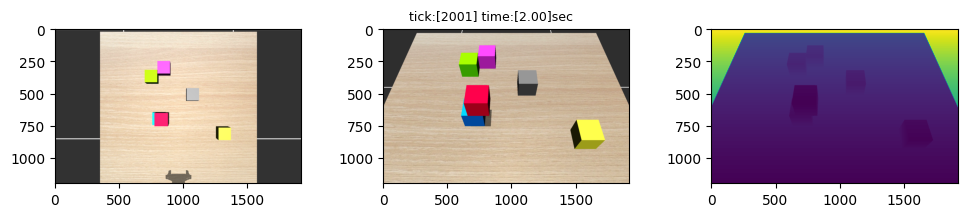

./block/horizontal/3/scene_img_1.png
horizontal: 0.7392316683111209
Moved object `obj_box_green` to ['0.739', '0.194', '0.848']


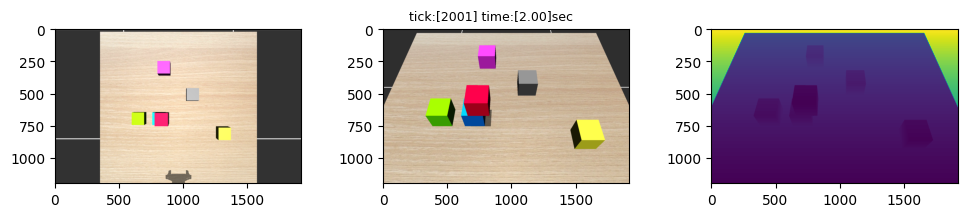

./block/horizontal/3/scene_img_2.png
horizontal: 0.7392316683111209
Moved object `obj_box_yellow` to ['0.739', '-0.022', '0.848']


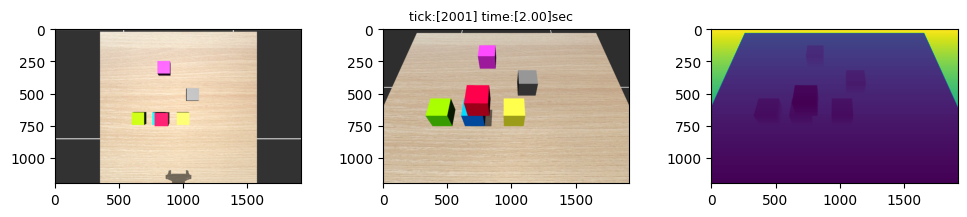

./block/horizontal/3/scene_img_3.png
horizontal: 0.7392316683111209
Moved object `obj_box_gray` to ['0.739', '0.071', '0.849']


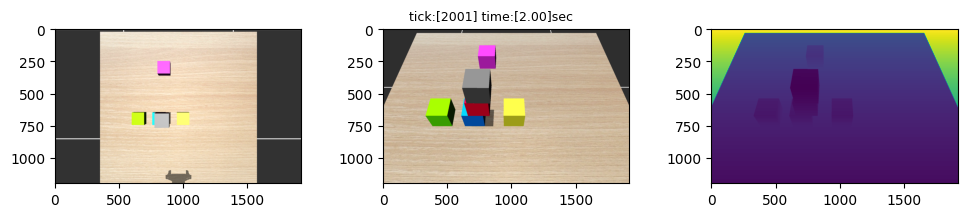

./block/horizontal/3/scene_img_4.png
horizontal: 0.7392316683111209
Moved object `obj_box_magenta` to ['0.739', '0.107', '0.849']


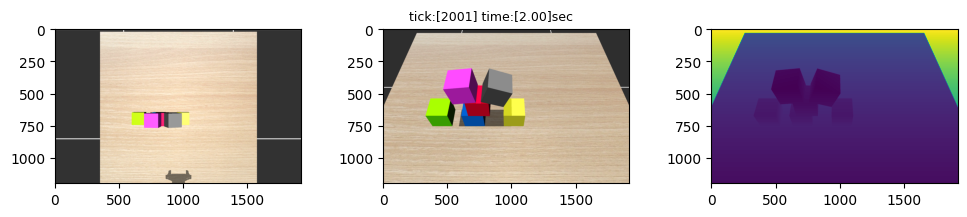

./block/horizontal/3/scene_img_5.png
MODE: offscreen
MODE: offscreen


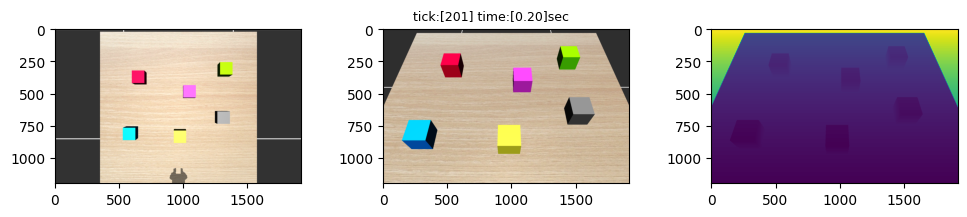

./block/horizontal/4/scene_img_0.png
horizontal: 0.9402650182578571
Moved object `obj_box_blue` to ['0.940', '0.048', '0.849']


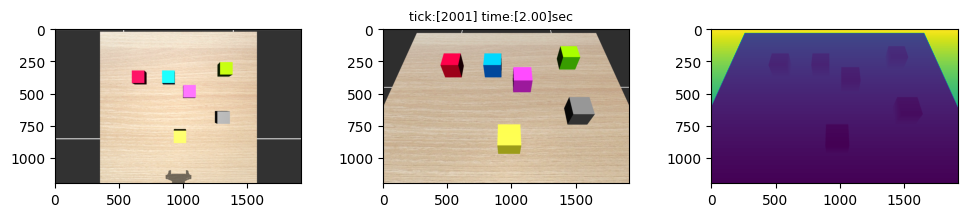

./block/horizontal/4/scene_img_1.png
horizontal: 0.9402650182578571
Moved object `obj_box_green` to ['0.940', '-0.029', '0.849']


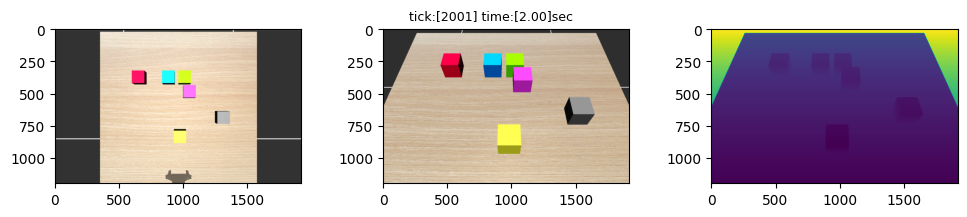

./block/horizontal/4/scene_img_2.png
horizontal: 0.9402650182578571
Moved object `obj_box_yellow` to ['0.940', '0.065', '0.847']


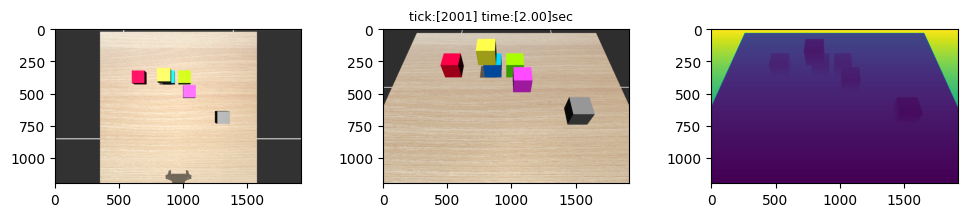

./block/horizontal/4/scene_img_3.png
horizontal: 0.9402650182578571
Moved object `obj_box_gray` to ['0.940', '-0.089', '0.849']


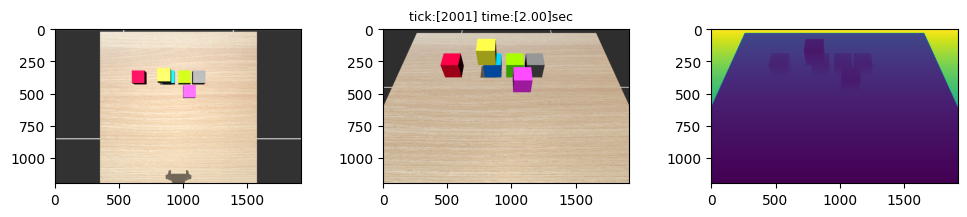

./block/horizontal/4/scene_img_4.png
horizontal: 0.9402650182578571
Moved object `obj_box_magenta` to ['0.940', '-0.221', '0.847']


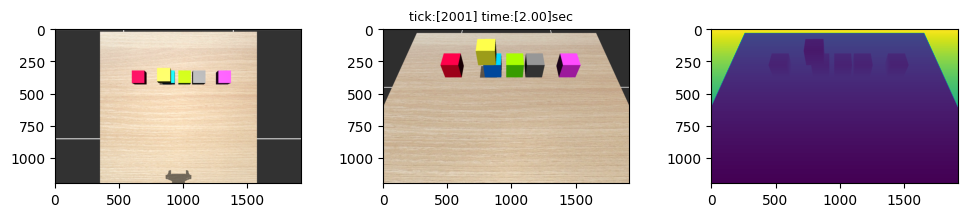

./block/horizontal/4/scene_img_5.png
[sample_xyzs] iter_tick:[1001] is over 1000.
MODE: offscreen
MODE: offscreen


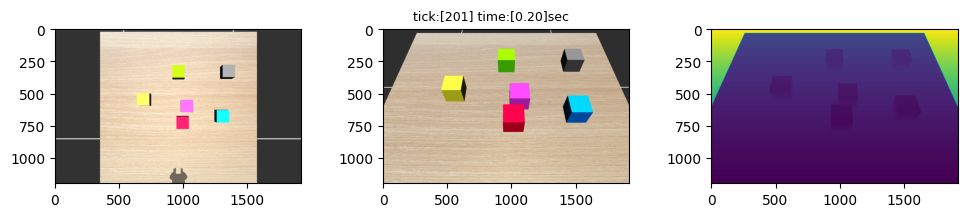

./block/horizontal/5/scene_img_0.png
horizontal: 0.8315958493827714
Moved object `obj_box_red` to ['0.832', '-0.096', '0.848']


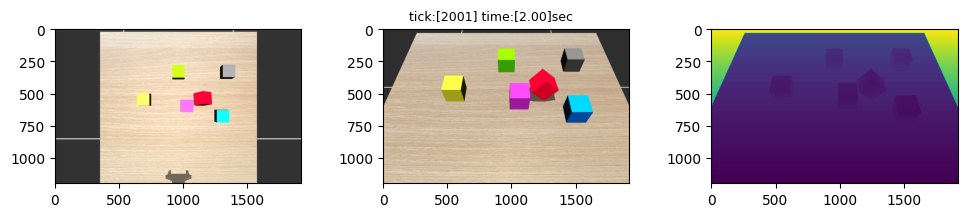

./block/horizontal/5/scene_img_1.png
horizontal: 0.8315958493827714
Moved object `obj_box_blue` to ['0.832', '-0.011', '0.849']


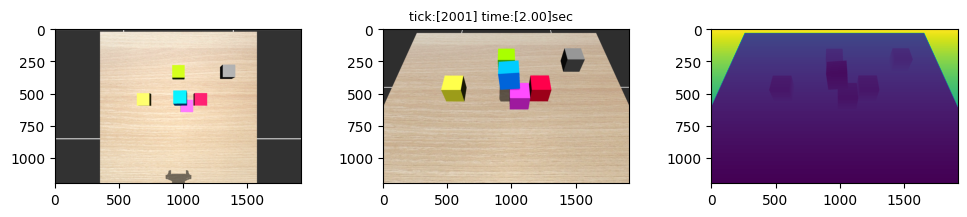

./block/horizontal/5/scene_img_2.png
horizontal: 0.8315958493827714
Moved object `obj_box_green` to ['0.832', '-0.158', '0.849']


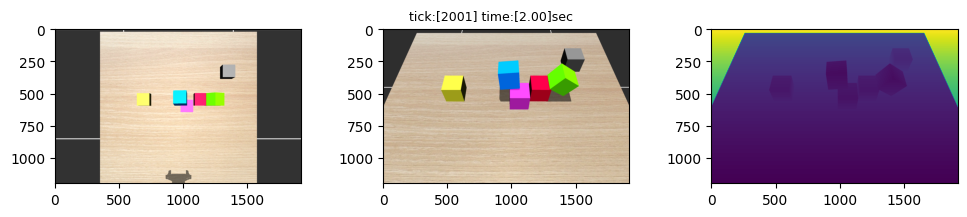

./block/horizontal/5/scene_img_3.png
horizontal: 0.8315958493827714
Moved object `obj_box_gray` to ['0.832', '-0.037', '0.847']


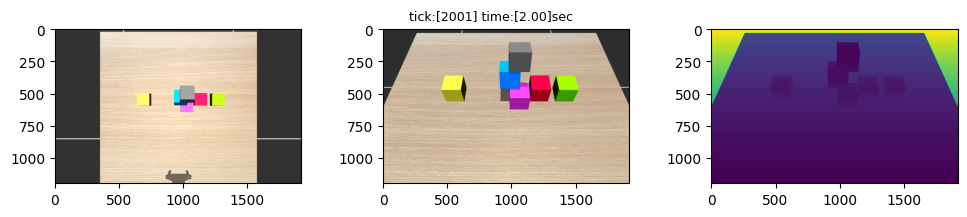

./block/horizontal/5/scene_img_4.png
horizontal: 0.8315958493827714
Moved object `obj_box_magenta` to ['0.832', '0.140', '0.849']


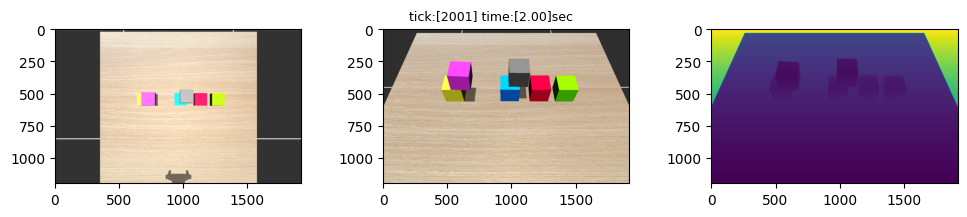

./block/horizontal/5/scene_img_5.png
[sample_xyzs] iter_tick:[1001] is over 1000.
MODE: offscreen
MODE: offscreen


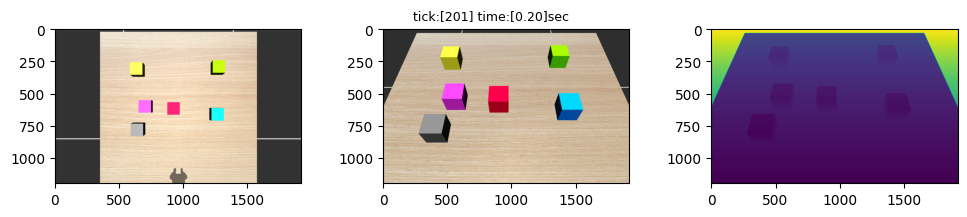

./block/horizontal/6/scene_img_0.png
horizontal: 0.7980576197784486
Moved object `obj_box_red` to ['0.798', '0.240', '0.849']


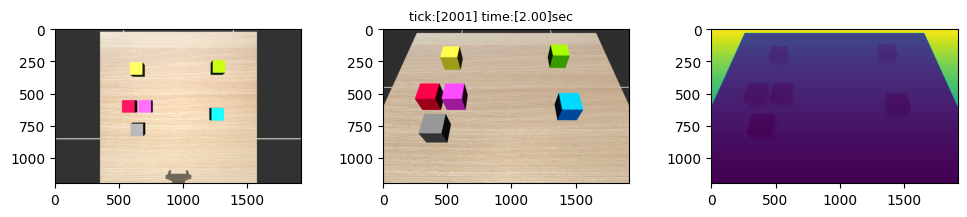

./block/horizontal/6/scene_img_1.png
horizontal: 0.7980576197784486
Moved object `obj_box_blue` to ['0.798', '-0.035', '0.849']


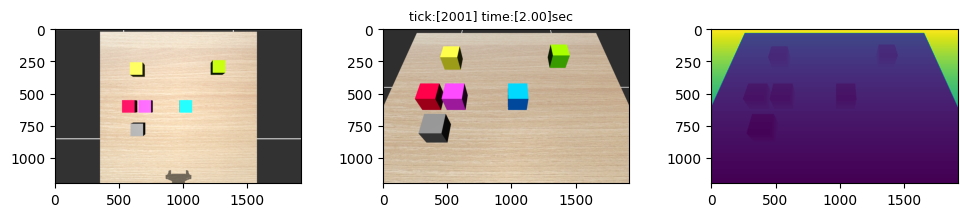

./block/horizontal/6/scene_img_2.png
horizontal: 0.7980576197784486
Moved object `obj_box_green` to ['0.798', '-0.358', '0.847']


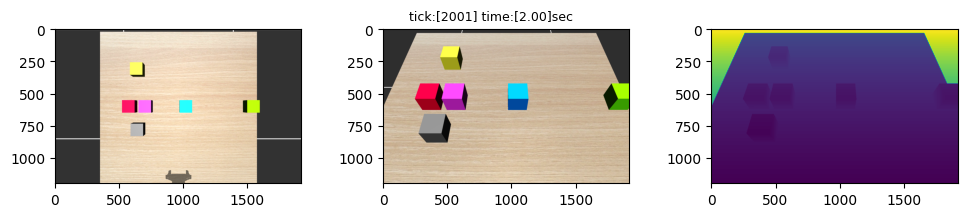

./block/horizontal/6/scene_img_3.png
horizontal: 0.7980576197784486
Moved object `obj_box_yellow` to ['0.798', '0.245', '0.850']


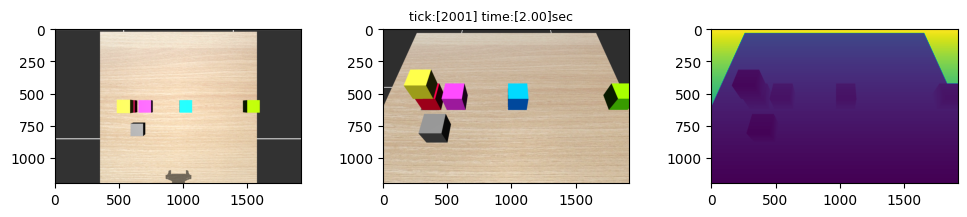

./block/horizontal/6/scene_img_4.png
horizontal: 0.7980576197784486
Moved object `obj_box_gray` to ['0.798', '0.172', '0.849']


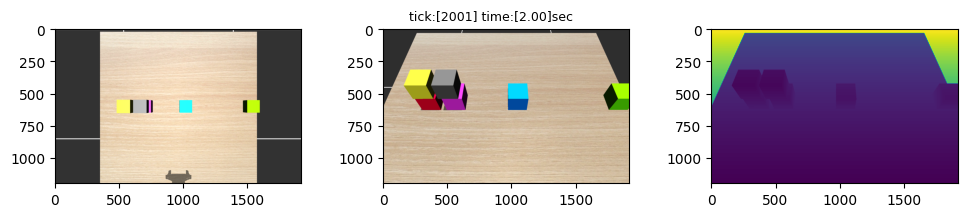

./block/horizontal/6/scene_img_5.png
[sample_xyzs] iter_tick:[1001] is over 1000.
MODE: offscreen
MODE: offscreen


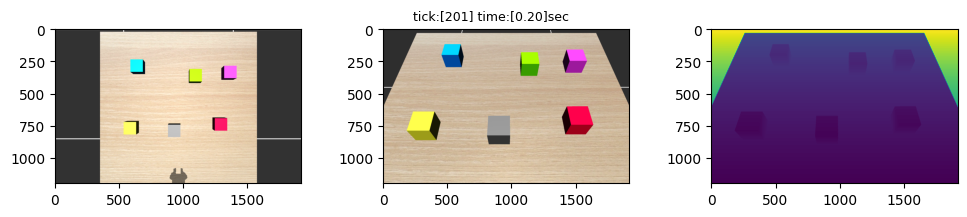

./block/horizontal/7/scene_img_0.png
horizontal: 0.9635437838486254
Moved object `obj_box_red` to ['0.964', '-0.166', '0.849']


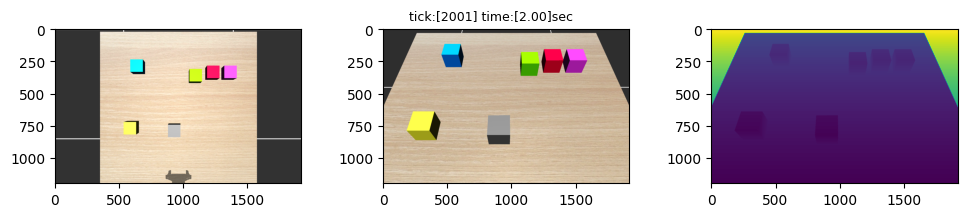

./block/horizontal/7/scene_img_1.png
horizontal: 0.9635437838486254
Moved object `obj_box_blue` to ['0.964', '-0.010', '0.849']


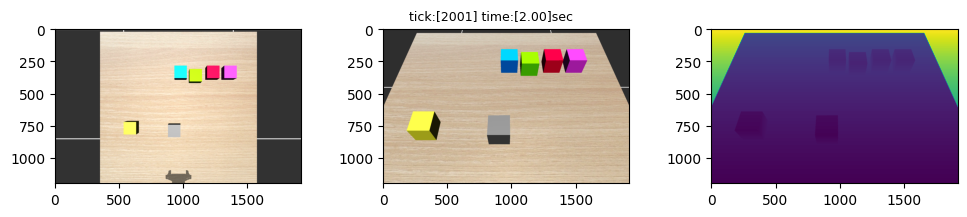

./block/horizontal/7/scene_img_2.png
horizontal: 0.9635437838486254
Moved object `obj_box_green` to ['0.964', '0.079', '0.848']


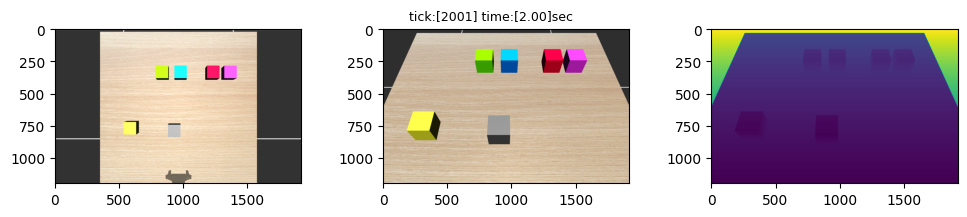

./block/horizontal/7/scene_img_3.png
horizontal: 0.9635437838486254
Moved object `obj_box_yellow` to ['0.964', '0.409', '0.849']


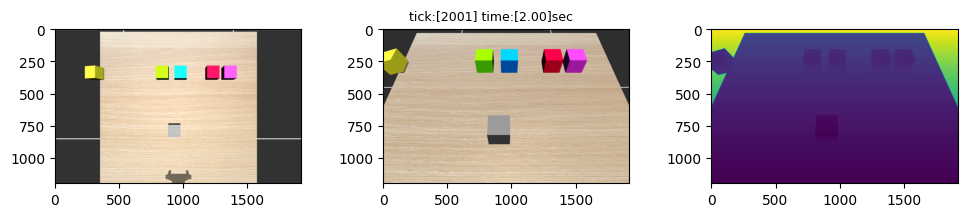

./block/horizontal/7/scene_img_4.png
horizontal: 0.9635437838486254
Moved object `obj_box_gray` to ['0.964', '-0.077', '0.848']


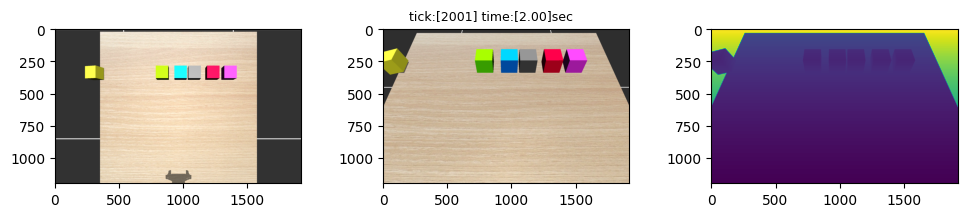

./block/horizontal/7/scene_img_5.png
MODE: offscreen
MODE: offscreen


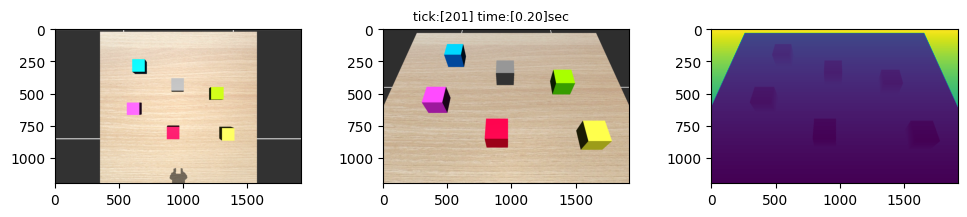

./block/horizontal/8/scene_img_0.png
horizontal: 0.9942480408050909
Moved object `obj_box_red` to ['0.994', '0.168', '0.849']


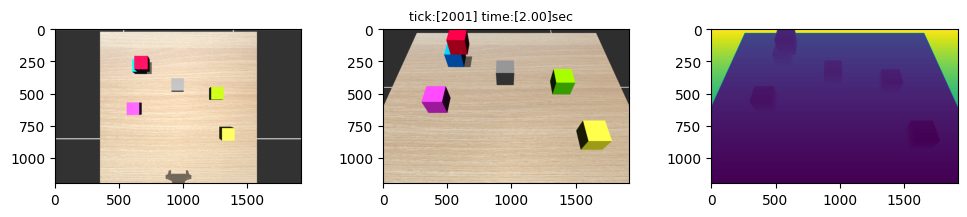

./block/horizontal/8/scene_img_1.png
horizontal: 0.9942480408050909
Moved object `obj_box_green` to ['0.994', '-0.055', '0.847']


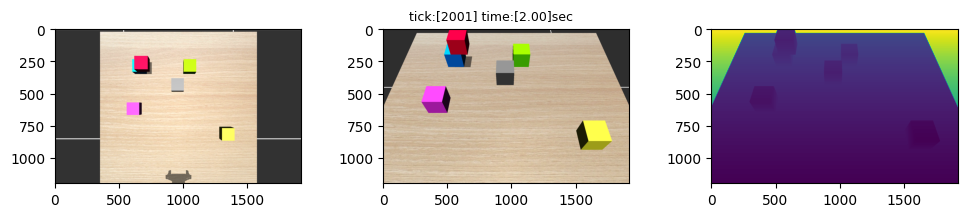

./block/horizontal/8/scene_img_2.png
horizontal: 0.9942480408050909
Moved object `obj_box_yellow` to ['0.994', '-0.211', '0.849']


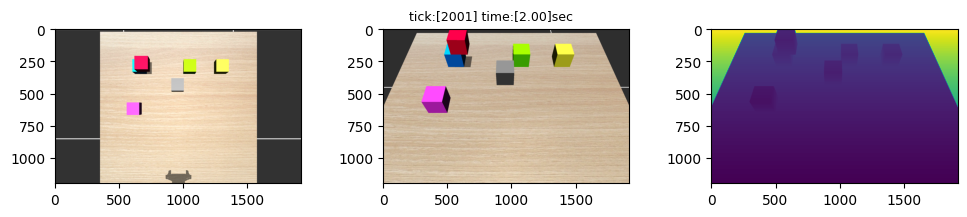

./block/horizontal/8/scene_img_3.png
horizontal: 0.9942480408050909
Moved object `obj_box_gray` to ['0.994', '0.226', '0.850']


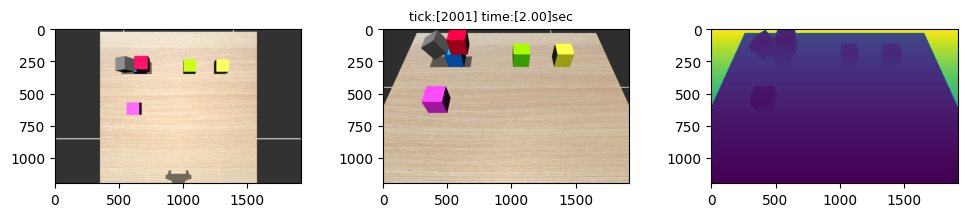

./block/horizontal/8/scene_img_4.png
horizontal: 0.9942480408050909
Moved object `obj_box_magenta` to ['0.994', '0.128', '0.847']


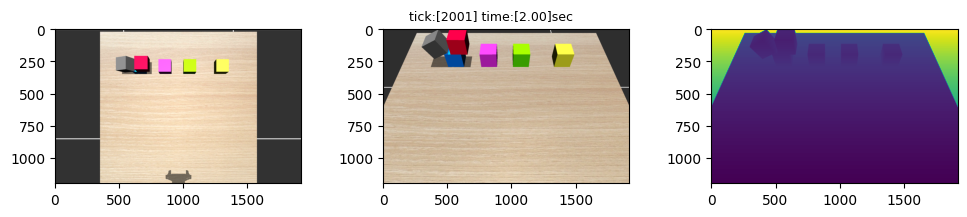

./block/horizontal/8/scene_img_5.png
[sample_xyzs] iter_tick:[1001] is over 1000.
MODE: offscreen
MODE: offscreen


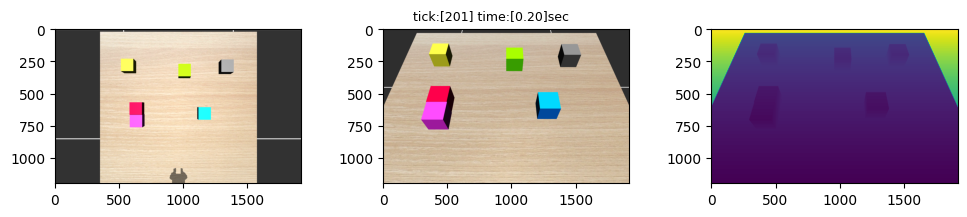

./block/horizontal/9/scene_img_0.png
horizontal: 0.9972280927099224
Moved object `obj_box_red` to ['0.997', '0.105', '0.849']


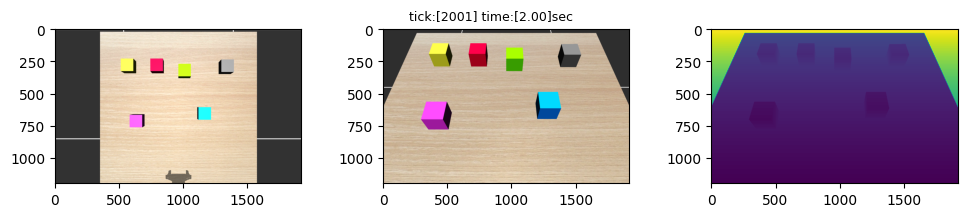

./block/horizontal/9/scene_img_1.png
horizontal: 0.9972280927099224
Moved object `obj_box_blue` to ['0.997', '0.072', '0.848']


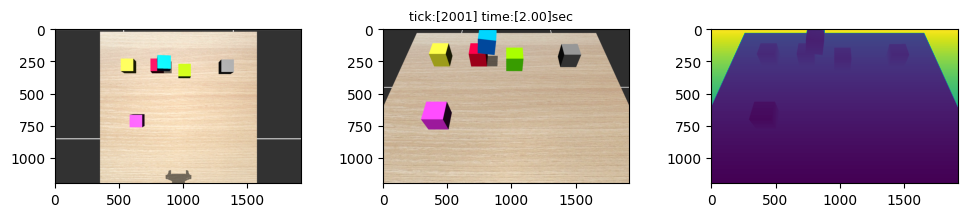

./block/horizontal/9/scene_img_2.png
horizontal: 0.9972280927099224
Moved object `obj_box_green` to ['0.997', '0.009', '0.849']


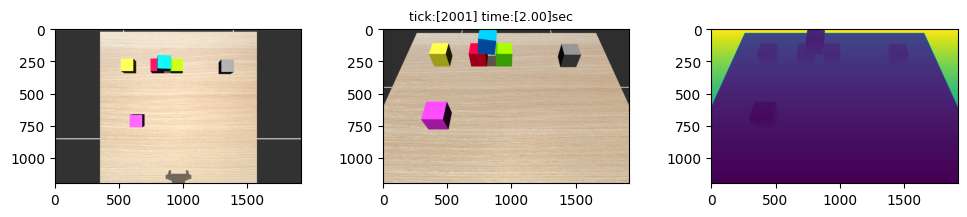

./block/horizontal/9/scene_img_3.png
horizontal: 0.9972280927099224
Moved object `obj_box_gray` to ['0.997', '-0.058', '0.849']


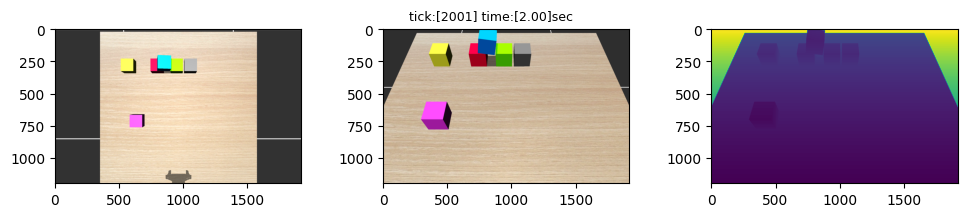

./block/horizontal/9/scene_img_4.png
horizontal: 0.9972280927099224
Moved object `obj_box_magenta` to ['0.997', '0.120', '0.849']


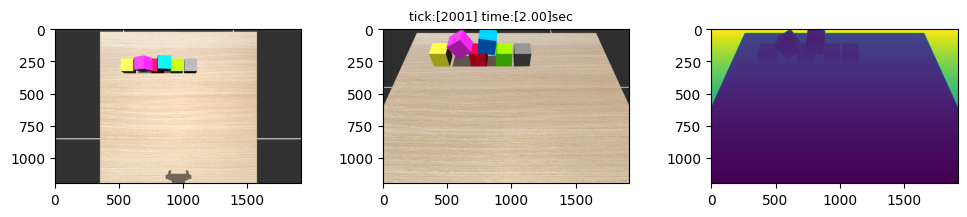

./block/horizontal/9/scene_img_5.png
MODE: offscreen
MODE: offscreen


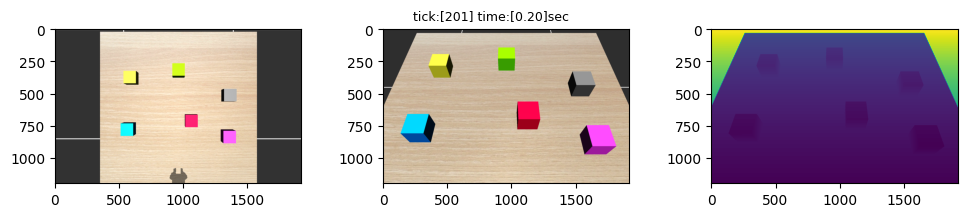

./block/horizontal/10/scene_img_0.png
horizontal: 0.7282792398586283
Moved object `obj_box_blue` to ['0.728', '0.254', '0.848']


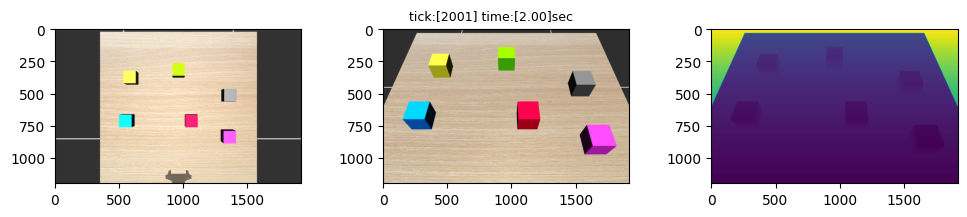

./block/horizontal/10/scene_img_1.png
horizontal: 0.7282792398586283
Moved object `obj_box_green` to ['0.728', '0.002', '0.848']


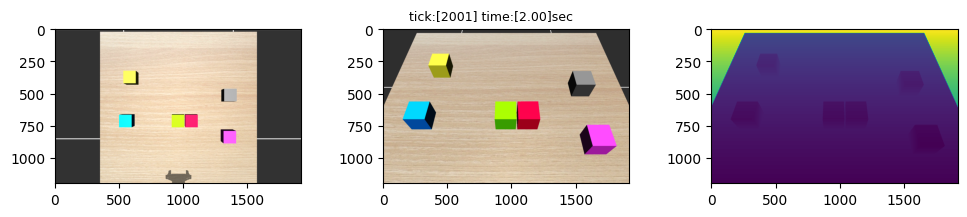

./block/horizontal/10/scene_img_2.png
horizontal: 0.7282792398586283
Moved object `obj_box_yellow` to ['0.728', '0.031', '0.848']


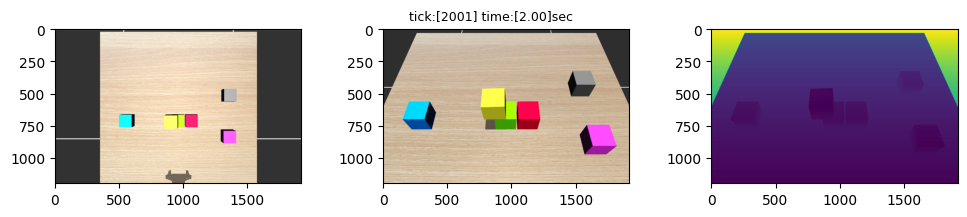

./block/horizontal/10/scene_img_3.png
horizontal: 0.7282792398586283
Moved object `obj_box_gray` to ['0.728', '-0.434', '0.848']


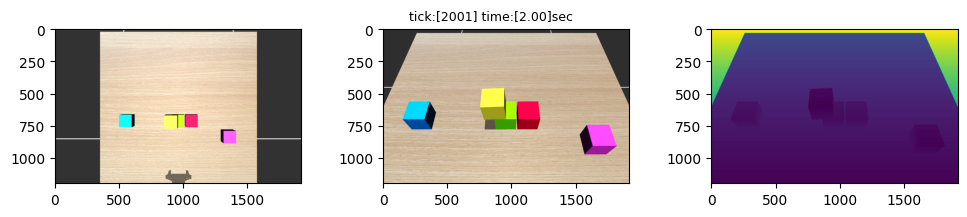

./block/horizontal/10/scene_img_4.png
horizontal: 0.7282792398586283
Moved object `obj_box_magenta` to ['0.728', '-0.373', '0.848']


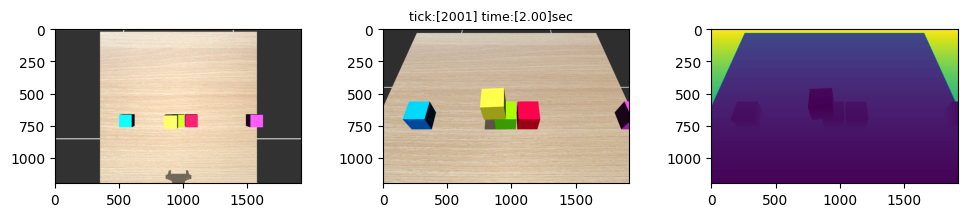

./block/horizontal/10/scene_img_5.png


In [7]:
for episode in range(10):
    FIX_AXIS = None
    preference_objective = ["upper", "lower", "center", "left", "right", "vertical", "horizontal"]
    rand_idx = np.random.randint(0,3)
    rand_preference = preference_objective[rand_idx]
    rand_preference = "left"
    rand_preference = "center"
    rand_preference = "horizontal"
    # rand_preference = "vertical"

    executed_action_list = []
    interaction_idx = 0

    random_sample_object(env, obj_box_names)
    env.set_viewer()
    env.reset()
    env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
    # Get images
    for _ in range(100): # for loop to place the object
        env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
        env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
        if env.loop_every(HZ=20):
            env.render(render_every=1)
    fig,axs = plt.subplots(1,3,figsize=(12,2))
    scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
    axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
    fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
    plt.subplots_adjust(wspace=0.2); plt.show()
    env.set_object_configuration(object_names=object_names)
    save_img(scene_img, rgb_img, 0, f'./block/{rand_preference}/{episode+1}/')

    # Get object positions according to the preference
    object_positions = get_object_positions(env, object_names)
    quadrants = get_quadrant_centers(env)

    # Place objects according to the preference
    reference = np.random.choice(object_names)
    for obj in object_names:
        if rand_preference in quadrants:
            if rand_preference == "upper":
                if (env.get_p_body(obj)[0] > 0.85):
                    continue
            elif rand_preference == "lower":
                if (env.get_p_body(obj)[0] < 0.75):
                    continue
            elif rand_preference == "left":
                if (env.get_p_body(obj)[1] > 0.15):
                    continue
            elif rand_preference == "right":
                if (env.get_p_body(obj)[1] < -0.15):
                    continue
            elif rand_preference == "center":
                center_position = quadrants[rand_preference] = np.array([0.78, 0., 0.7])
                if (env.get_p_body(obj)[0] - center_position[0] < 0.075) and (env.get_p_body(obj)[1] - center_position[1] < 0.075):
                    continue
            target_position = quadrants[rand_preference]
            env.move_object(obj, target_position, outer_margin=0.125, FIX_AXIS=FIX_AXIS)
            executed_action_list.append(f"align_objects(env, object_names, {rand_preference}, {target_position})")
            env.reset()
            env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
            # Get images
            for _ in range(200): # for loop to place the object
                env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
                env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
                if env.loop_every(HZ=20):
                    env.render(render_every=1)
            fig,axs = plt.subplots(1,3,figsize=(12,2))
            scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
            axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
            fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
            plt.subplots_adjust(wspace=0.2); plt.show()
            env.set_object_configuration(object_names=object_names)
            save_img(scene_img, rgb_img, interaction_idx+1, f'./block/{rand_preference}/{episode+1}/')
            interaction_idx += 1
            env.close_viewer()
        elif rand_preference in ["vertical", "horizontal"]:
            if obj != reference: # except for reference object
                target_position = list(object_positions[obj])
                if rand_preference == "horizontal":
                    target_position[0] = object_positions[reference][0] # fix X
                    print(f"horizontal: {object_positions[reference][0]}")
                    FIX_AXIS = 'x'
                elif rand_preference == "vertical":
                    target_position[1] = object_positions[reference][1] # fix Y
                    FIX_AXIS = 'y'
                env.move_object(obj, target_position, inner_margin=0.2, outer_margin=0.225, FIX_AXIS=FIX_AXIS)
                executed_action_list.append(f"align_objects(env, object_names, {rand_preference}, {target_position})")
                env.reset()
                env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
                # Get images
                for _ in range(1000): # for loop to place the object
                    env.forward(q=init_pose,joint_idxs=idxs_ur_fwd)
                    env.step(ctrl=np.append(init_pose,1.0),ctrl_idxs=idxs_ur_step+[6])
                    if env.loop_every(HZ=20):
                        env.render(render_every=1)
                fig,axs = plt.subplots(1,3,figsize=(12,2))
                scene_img,rgb_img,depth_img = env.get_image_both_mode(body_name='ur_camera_center')
                axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
                fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=9)
                plt.subplots_adjust(wspace=0.2); plt.show()
                env.set_object_configuration(object_names=object_names)
                save_img(scene_img, rgb_img, interaction_idx+1, f'./block/{rand_preference}/{episode+1}/')
                interaction_idx += 1
                env.close_viewer()